# Initialize LDA
We find that n_components = 10 and learning_decay = 0.7 was the best after trying it out with n_components = 10, 20, 30 and learning_decay = 0.5, 0.7 and 0.9 respectively

To model with LDA, modeling suicidal text with the label as that is of our interest


In [ ]:
#!pip install symspellpy
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install fast_ml
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 4.9 MB/s eta 0:00:00
The scikit-learn version is 1.2.1.


In [ ]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

import re # The following statement imports the regex package.
import gensim # The following statement imports the gensim package.
import nltk # The following statement imports the NLTK package.
import pkg_resources
import pandas as pd
import os
import numpy as np
#from symspellpy import SymSpell, Verbosity
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/TxtAnalytics_Proj

Mounted at /content/gdrive
/content/gdrive/MyDrive/TxtAnalytics_Proj


In [ ]:
#data_raw =  pd.read_pickle("posts_after_lemmatized.pkl")
df_filtered =  pd.read_pickle("posts_after_lemmatized.pkl")

In [ ]:
#data_raw["class"] = data_raw["class"].apply(lambda x: 1 if x =="suicide" else 0)
#df_filtered = data_raw.loc[lambda x: x['class'] == 1]
#df_filtered.head()

,Unnamed: 0,text,class,text_lemmatized_with_postag,text_lemmatized
0,2,sex wife threatening suicide recently left wif...,1,"[[(sex, sex, ['NN']), (wife, wife, ['NN']), (t...","[sex, wife, threaten, suicide, recently, leave..."
3,8,need help help crying hard,1,"[[(need, need, ['NN']), (help, help, ['NN']), ...","[need, help, help, cry, hard]"
4,9,lost hello adam live struggling years afraid p...,1,"[[(lost, lose, ['VBN']), (hello, hello, ['JJ']...","[lose, hello, adam, live, struggle, year, afra..."
5,11,honestly id know feel like feel unbearably sad...,1,"[[(honestly, honestly, ['RB']), (id, id, ['RB'...","[honestly, id, know, feel, like, feel, unbeara..."
6,12,trigger warning excuse self inflicted burns kn...,1,"[[(trigger, trigger, ['NN']), (warning, warn, ...","[trigger, warn, excuse, self, inflict, burn, k..."


In [ ]:

import fast_ml
from fast_ml.model_development import train_valid_test_split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_filtered, target = 'class', 
                                                                            train_size=0.7, valid_size=0.2, test_size=0.1)

In [ ]:
X_train.head()
print(X_train.shape)

(81225, 4)


In [ ]:
#df_filtered.to_pickle("posts_after_lemmatized.pkl")

X_train.to_pickle("X_Train.pkl")
X_valid.to_pickle("X_valid.pkl")
X_test.to_pickle("X_test.pkl")

y_train.to_pickle("y_Train.pkl")
y_valid.to_pickle("y_valid.pkl")
y_test.to_pickle("y_test.pkl")


In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # min occurrences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=False,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )


X_train = pd.read_pickle("X_Train.pkl")
df_filtered_lemmatized = X_train["text_lemmatized"].tolist()

stop_list = ("suicidal", "suicide", "aah", "fuck")
df_filtered_lemmatized_removeSuicide = [[w for w in doc if w not in stop_list] for doc in df_filtered_lemmatized]
df_filtered_lemmatized_joined = [' '.join(x) for x in df_filtered_lemmatized_removeSuicide]  # joined to fit CountVectorizer
train1_vecs = vectorizer.fit_transform(df_filtered_lemmatized_joined)
feature_names = vectorizer.get_feature_names_out()
# display the first 20 tokens
feature_names[:20]

array(['aaron', 'aba', 'aback', 'abandon', 'abandoned', 'abandonment',
       'abdomen', 'abdominal', 'abhor', 'abhorrent', 'abide', 'ability',
       'abject', 'able', 'abnormal', 'abnormality', 'abnormally',
       'abomination', 'abort', 'aborted'], dtype=object)

In [ ]:
lda_suicidal_model = LatentDirichletAllocation(
             batch_size=128, 
             learning_decay=0.7,
             n_components=10,
             learning_method = 'online'
            )

In [ ]:
# Materialize the sparse data
data_dense = train1_vecs.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.45877252799719836 %


In [ ]:
lda_output = lda_suicidal_model.fit_transform(train1_vecs)

print(lda_suicidal_model)  # Model attributes

LatentDirichletAllocation(learning_method='online')


In [ ]:
# a utility function to display the topics and for each topic we choose the top most frequent words
def display_topics(model, feature_names, num_top_words):
    for topic_id, topic in enumerate(model.components_):
        print(f'Topic {topic_id}')
        print(' '.join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=15):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

def show_doc_topic_matrix(model, vecs, num_doc_to_show = 10, to_styler=True):
    # model = a trained sklearn lda model
    # vecs = output from the CountVectorizer transform
    lda_output = model.transform(vecs)
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 6), 
                                     columns=[f'topic{i}' for i in range(model.n_components)], 
                                     index=[f'doc{i}' for i in range(vecs.shape[0])])

    # Get dominant topic for each document
    df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)



    # apply style and return the dataframe
    df_out = df_document_topic.head(num_doc_to_show)
    if to_styler:
        return df_out.style.applymap(color_green).applymap(make_bold)
    else:
        return df_out
    
# Styling
def color_green(val):
    if 0 < val < 1:
        color = 'black' if val > .1 else 'grey'
        return f'color: {color}'

def make_bold(val):
    if 0 < val < 1:
        weight = 'bold' if val > .1 else 'lighter'
        return f'font-weight: {weight}'

In [ ]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_suicidal_model)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,school,college,high,parent,class,year,grade,fail,game,study,play,graduate,university,video,start
Topic 1,job,work,live,money,pay,month,time,need,try,help,week,year,home,day,car
Topic 2,life,love,live,world,want,hate,die,wish,end,good,people,hope,person,deserve,pain
Topic 3,want,head,die,day,night,sleep,kill,think,cut,wake,pill,try,ill,stop,time
Topic 4,life,people,thing,way,experience,live,world,change,think,mind,point,self,fear,believe,society
Topic 5,like,people,friend,girl,look,shit,guy,hate,amp,talk,ugly,woman,lonely,stupid,say
Topic 6,help,know,need,talk,tell,post,say,ask,write,friend,sure,read,sorry,thank,thought
Topic 7,year,time,live,friend,tell,start,know,want,didst,day,thing,month,think,like,family
Topic 8,pain,kill,jump,attempt,hospital,doctor,plan,way,method,pill,overdose,bridge,painful,train,cause
Topic 9,feel,want,like,live,know,think,life,people,anymore,time,try,thing,kill,bad,die


In [ ]:
df = show_doc_topic_matrix(lda_suicidal_model, train1_vecs, num_doc_to_show = 20, to_styler=False)
df.style.applymap(color_green).applymap(make_bold)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,dominant_topic
doc0,0.020000,0.020002,0.020000,0.020000,0.020000,0.020001,0.355834,0.020003,0.020000,0.484160,9
doc1,0.441824,0.066571,0.009305,0.018575,0.190361,0.030439,0.000361,0.241843,0.000361,0.000361,0
doc2,0.005263,0.005264,0.005265,0.265053,0.005263,0.005264,0.005267,0.692831,0.005264,0.005264,7
doc3,0.005264,0.005264,0.005264,0.619489,0.005264,0.005264,0.005265,0.005265,0.005264,0.338397,3
doc4,0.003334,0.003334,0.807949,0.003334,0.003335,0.003334,0.003334,0.003334,0.003333,0.165380,2
doc5,0.003847,0.069535,0.625454,0.003849,0.003847,0.003847,0.278079,0.003848,0.003846,0.003847,2
doc6,0.016667,0.016668,0.016672,0.016669,0.016668,0.016667,0.016667,0.016668,0.016667,0.849988,9
doc7,0.020000,0.020001,0.020001,0.020001,0.020005,0.020003,0.020009,0.020003,0.329851,0.510126,9
doc8,0.001923,0.365540,0.094900,0.001923,0.001924,0.069004,0.026800,0.434138,0.001923,0.001924,7
doc9,0.013094,0.671345,0.014384,0.039653,0.022064,0.000699,0.139701,0.021639,0.000699,0.076721,1


In [ ]:
import joblib

# Save a model to disk
joblib.dump(lda_suicidal_model, 'suicidal_lda_model.jl')


['suicidal_lda_model.jl']

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

#import pickle
#with open('trained_vectors.pkl', 'wb') as f:
#  pickle.dump(df_filtered_lemmatized_removeSuicide, f)
  
#df_filtered_lemmatized_removeSuicide.to_pickle("trained_vectors.pkl")



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.4 MB/s eta 0:00:00


In [ ]:

print('The pyLDAvis-learn version is {}.'.format(pyLDAvis.__version__))
panel = pyLDAvis.lda_model.prepare(lda_suicidal_model, train1_vecs, vectorizer, mds='tsne')
panel
# Save the output|to the html file
#

The pyLDAvis-learn version is 3.4.0.


/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9      127.707809 -176.299042       1        1  30.705758
7      103.384117  133.565826       2        1  21.631629
4      -65.212433  164.787186       3        1   7.774806
2       -6.832249 -127.345573       4        1   7.378786
1     -142.586777 -171.691727       5        1   7.325041
6       97.963043  -33.584969       6        1   7.143931
3       -6.809081   39.524063       7        1   6.841670
5     -116.794601  -32.303024       8        1   4.970502
0      225.452316    7.750899       9        1   3.774035
8     -202.024536   71.945114      10        1   2.453843, topic_info=         Term          Freq         Total Category  logprob  loglift
5779     like  94061.000000  94061.000000  Default  30.0000  30.0000
8749   school  24229.000000  24229.000000  Default  29.0000  29.0000
5761     life  81895.000000  81895.000000  Default  28.0000  28.0000
3690     feel  93337.000000  93337.000000  Default  27.0000  27.0000
4578     help  40188.000000  40188.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1041     body   1053.839226   5812.346492  Topic10  -4.8837   2.0000
11023     way   1612.863813  29104.564105  Topic10  -4.4581   0.8146
9746   suffer   1056.101425   6742.223277  Topic10  -4.8816   1.8537
1770   commit    867.939974   5186.909877  Topic10  -5.0778   1.9197
4381      gun    778.328044   3342.409416  Topic10  -5.1868   2.2502

[748 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
11         1  0.062690  ability
11         2  0.103135  ability
11         3  0.833169  ability
13         1  0.415842     able
13         2  0.168267     able
...      ...       ...      ...
11274      8  0.001469     year
11274      9  0.101695     year
11274     10  0.000114     year
11296      9  0.999116  youtube
11308      6  0.996424   zoloft

[1868 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 5, 3, 2, 7, 4, 6, 1, 9])

In [ ]:
pyLDAvis.save_html(panel, 'topic_viz_sklearn2.html')

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_suicidal_model.score(train1_vecs))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_suicidal_model.perplexity(train1_vecs))
# See model parameters
print(lda_suicidal_model.get_params())

Log Likelihood:  -39680646.58411444
Perplexity:  1089.2723041878169
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [ ]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_suicidal_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
topicnames = ["Topic" + str(i) for i in range(lda_suicidal_model.n_components)]
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,aaron,aba,aback,abandon,abandoned,abandonment,abdomen,abdominal,abhor,abhorrent,...,zine,zing,zip,zola,zoloft,zombie,zone,zoo,zoom,zzz
Topic0,0.100053,12.581406,0.100014,0.100048,0.100072,0.100032,0.100072,0.100142,8.884956,0.100017,...,0.100009,0.100029,56.651985,0.100021,0.100021,0.100066,0.100031,0.100021,0.100091,0.100033
Topic1,0.100023,0.100042,0.100020,0.100037,24.873568,0.100022,0.100019,0.100039,0.100031,0.100014,...,0.100004,0.100036,0.100028,0.100027,0.100021,0.100034,161.079527,0.100034,0.100058,0.100042
Topic2,19.259319,0.100052,15.323657,1163.415616,0.100067,61.344352,3.913244,0.100048,0.100020,0.100017,...,0.100003,26.407052,0.100050,0.100008,0.100024,0.100024,0.100034,0.168040,70.974816,0.100014
Topic3,0.100092,0.100013,0.100012,0.100041,0.100112,0.100023,0.100046,0.100118,0.100026,0.100011,...,0.100011,0.100035,0.100063,0.100014,0.100024,0.100019,0.100030,0.100021,0.100049,0.100008
Topic4,0.100062,0.100020,0.100039,0.100039,0.100067,0.100023,0.100071,0.100269,0.100009,0.100016,...,28.276033,0.100020,0.100029,22.010847,0.100057,0.100028,53.070735,0.100021,0.100044,12.109798


In [ ]:
#!spacy download en_core_web_sm

# Define function to predict topic for a given text document.
#!pip install -U spacy
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def predict_topic(model, vectorizer, text):
    global sent_to_words
    global lemmatization
    
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 0:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topicNo = np.argmax(topic_probability_scores)
    infer_topic = df_topic_keywords.iloc[infer_topicNo, -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, infer_topicNo, topic_probability_scores


In [ ]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.05  0.09  0.14  0.12  0.1   0.07  0.12  0.26  0.05  0.92]
 [ 0.06  0.17  0.17  0.22  0.11  0.09  0.2   0.84  0.06 -0.36]]
Perc of Variance Explained: 
 [0.23 0.25]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

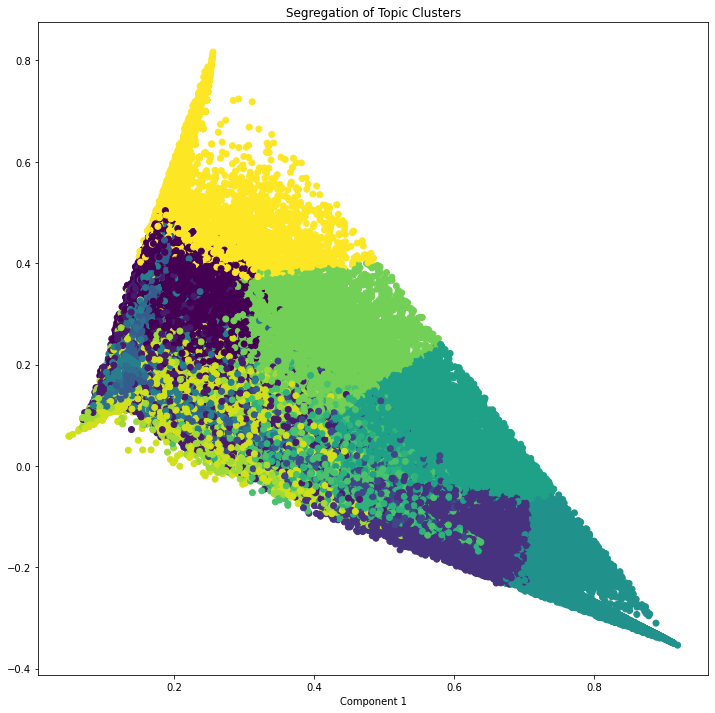

In [ ]:
import matplotlib.pyplot as plot

plot.figure(figsize=(12, 12))
plot.scatter(x, y, c=clusters)
plot.xlabel('Component 2')
plot.xlabel('Component 1')
plot.title("Segregation of Topic Clusters", )

In [ ]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import pickle

#with open('trained_vectors.pkl', 'rb') as f:
#    train1_vecs = pickle.load(f)
#print('The joblib version is {}.'.format(joblib.__version__))


# Save a model to disk
#joblib.dump(lda_suicidal_model, 'suicidal_lda_model.jl')


The joblib version is 1.2.0.


FileNotFoundError: ignored

In [ ]:
mytext = ["i wanna go make sweet love so bad"]
infer_topic, topic, infer_topicNo, prob_scores = predict_topic(lda_suicidal_model, vectorizer = vectorizer, text = mytext)
print(topic)
print("Topic: " + str(infer_topicNo) + " " + infer_topic)

['year', 'time', 'live', 'friend', 'tell', 'start', 'know', 'want', 'didst', 'day', 'thing', 'month', 'think', 'like']
Topic: 7 family
